## Run on Colab
You can run this notebook on Colab right away without installing JAX dependencies: https://colab.research.google.com/github/willwhitney/reprieve/blob/master/examples/example.ipynb.

## Run locally
To run this notebook locally please install the [Reprieve dependencies](https://github.com/willwhitney/reprieve#dependencies), in particular JAX with GPU support.

In [1]:
# !pip install flax git+https://github.com/willwhitney/reprieve
!pip uninstall -y reprieve
!pip install --user -e /misc/vlgscratch4/LecunGroup/katrina/dev/reprieve

Found existing installation: reprieve 0.0.1
Uninstalling reprieve-0.0.1:
  Successfully uninstalled reprieve-0.0.1
ERROR: /misc/vlgscratch4/LecunGroup/katrina/dev/reprieve is not a valid editable requirement. It should either be a path to a local project or a VCS URL (beginning with svn+, git+, hg+, or bzr+).


In [10]:
import os
import pandas as pd

import jax
import torchvision

import reprieve
from reprieve.representations import mnist_vae
from reprieve.mnist_noisy_label import MNISTNoisyLabelDataset
from reprieve.algorithms import mlp as alg

from argparse import Namespace
from functools import reduce
import numpy as np
import torch
from torch.utils.data import Dataset

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import os, sys, inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
targetdir = os.path.dirname(currentdir) + '/reprieve'
sys.path.insert(0, targetdir)

import dataset_wrappers
import utils

In [3]:
class SpectralDataset(Dataset):
    """Dataset with different frequencies."""

    def __init__(self, t, yt, transform=None, binary=False):
        """
        Args:
            t: inputs
            yt: targets
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.t = torch.from_numpy(t).view(-1, 1)
        if binary:
            self.yt = torch.from_numpy(yt>0).int()
        else:
            self.yt = torch.from_numpy(yt)
        self.transform = transform

    def __len__(self):
        return len(self.t)

    def __getitem__(self, idx):
        sample = (self.t[idx], self.yt[idx])
        if self.transform:
            sample = self.transform(sample)

        return sample

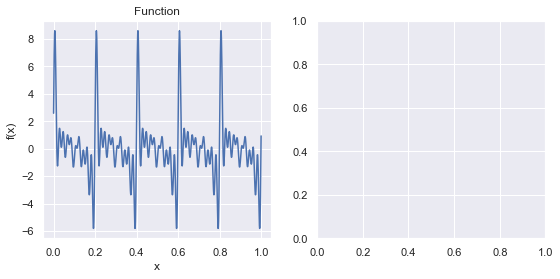

In [4]:
# Data Generation with constant amplitude of 1 for all frequencies
opt = Namespace()
opt.N = 1000
opt.K = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
opt.A = [1 for _ in opt.K]
opt.PHI = [np.random.rand() for _ in opt.K]

def make_phased_waves(opt):
    t = np.arange(0, 1, 1./opt.N)
    if opt.A is None:
        yt = reduce(lambda a, b: a + b, 
                    [np.sin(2 * np.pi * ki * t + 2 * np.pi * phi) for ki, phi in zip(opt.K, opt.PHI)])
    else:
        yt = reduce(lambda a, b: a + b, 
                    # [Ai * np.sin(2 * np.pi * ki * t + 2 * np.pi * phi) for ki, Ai, phi in zip(opt.K, opt.A, opt.PHI)])
                    [Ai * np.sin(2 * np.pi * ki * t + phi) for ki, Ai, phi in zip(opt.K, opt.A, opt.PHI)])
    return t, yt

def plot_wave_and_spectrum(opt, x, yox):
    # Btw, "yox" --> "y of x"
    # Compute fft
#     k, yok = fft(opt, yox)
    # Plot
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(9, 4))
    ax0.set_title("Function")
    ax0.plot(x, yox)
    ax0.set_xlabel("x")
    ax0.set_ylabel("f(x)")
#     ax1.set_title("FT of Function")
#     ax1.plot(k, yok)
#     ax1.set_xlabel("k")
#     ax1.set_ylabel("f(k)")
    plt.show()

x, y = make_phased_waves(opt)
plot_wave_and_spectrum(opt, x, y)

In [5]:
t, yt = make_phased_waves(opt)
dataset_spectral = SpectralDataset(t, yt)

In [6]:
dataset_spectral.__getitem__(0)

(tensor([0.], dtype=torch.float64), tensor(2.5788, dtype=torch.float64))

In [7]:
len(dataset_spectral)

1000

In [8]:
# make an MLP algorithm which takes inputs of shape (1,)
# has 1 output classes (regression)
# and has different depths
results_list = []
for depth in range(1, 4):
    init_fn, train_step_fn, eval_fn = alg.make_algorithm((1,), 1, n_layers=depth, h_dim=10)

    # these functions initialize the state of the model given a seed, 
    # train on a batch of data, 
    # and evaluate on a batch of data

    # construct a loss-data estimator and use it to compute the loss-data curve
    loss_data_estimator = reprieve.LossDataEstimator(
        init_fn, train_step_fn, eval_fn, dataset_spectral)
    results = loss_data_estimator.compute_curve()
    # name experiments 
    results['name'] = f'Layers-{depth}'
    results_list.append(results)

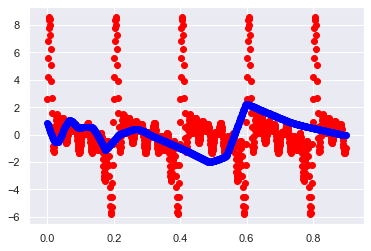

In [19]:
# make an MLP algorithm which takes inputs of shape (1,)
# has 1 output classes (regression)
# and has different depths
batch_size = 256
preds_list = []
for depth in range(1, 4):
    init_fn, train_step_fn, eval_fn = alg.make_algorithm((1,), 1, n_layers=depth, h_dim=1000)
    loss_data_estimator = reprieve.LossDataEstimator(init_fn, train_step_fn, eval_fn, dataset_spectral)
    # Use _train
    train_set = dataset_wrappers.DatasetSubset(
        dataset_spectral, stop=int(0.9*len(dataset_spectral)))
    state = loss_data_estimator._train(seed=11, dataset=train_set)
    train_set = utils.dataset_to_jax(
        train_set,
        batch_transforms=[lambda x: x],
        batch_size=batch_size)
    preds = state.target(train_set[0])
    plt.scatter(train_set[0], train_set[1], color='red')
    plt.scatter(train_set[0], preds, color='blue')

In [34]:
# concatenate experiments
outcome_df = pd.concat(results_list)

# pick some settings of n (training set size) and epsilon (loss tolerance)
ns = [20, 100, 200, 1000]
epsilons = [7, 4]

In [35]:
# plot the loss-data curves for our representations
reprieve.render_curve(outcome_df, ns, epsilons)

alt.LayerChart(...)

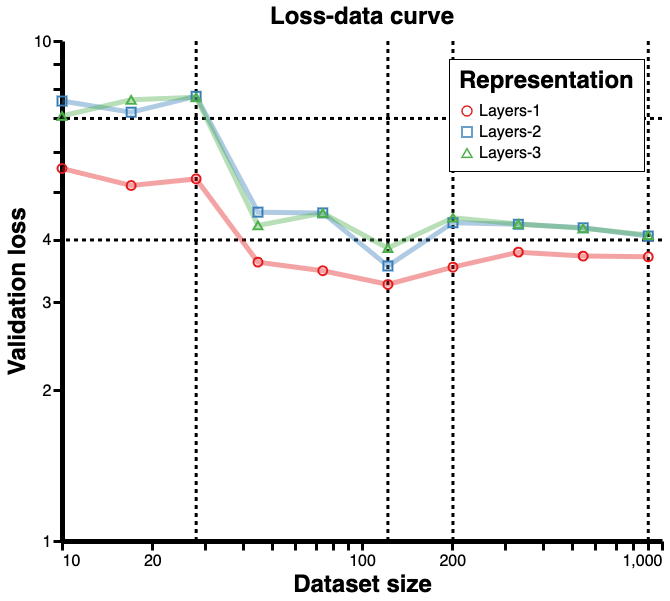

In [1]:
from IPython.display import Image
Image(filename='/Users/kati/Documents/CDS/research/IB/notes/smoother.png')

In [36]:
# compute VA, MDL, SDL, and eSC for both representations
metrics_df = reprieve.compute_metrics(outcome_df, ns, epsilons)
metrics_df

Name,Layers-1,Layers-2,Layers-3,Layers-1,Layers-2,Layers-3,Layers-1,Layers-2,Layers-3,Layers-1,Layers-2,Layers-3
n,28.0,28.0,28.0,122.0,122.0,122.0,201.0,201.0,201.0,900.0,900.0,900.0
Val loss,5.29886,7.75234,7.71619,3.25915,3.5489,3.85255,3.52891,4.33032,4.43242,3.70092,4.07298,4.09067
MDL,149.87,211.56,209.06,468.4,590.6,598.03,747.18,932.7,948.2,3347.4,3843.04,3863.54
"SDL, eps=7",0.0,> 15.56,> 13.06,0.0,15.56,13.06,0.0,15.56,13.06,0.0,15.56,13.06
"SDL, eps=4",> 37.87,> 99.56,> 97.06,37.87,124.25,117.11,37.87,> 150.35,> 151.27,37.87,> 264.69,> 270.62
"eSC, eps=7",10,> 28.0,> 28.0,10,45,45,10,45,45,10,45,45
"eSC, eps=4",> 28.0,> 28.0,> 28.0,45,122,122,45,122,122,45,122,122


In [11]:
# # reprieve even generates LaTeX tables you can paste into a paper
# latex_text = reprieve.render_latex(metrics_df, display=True)

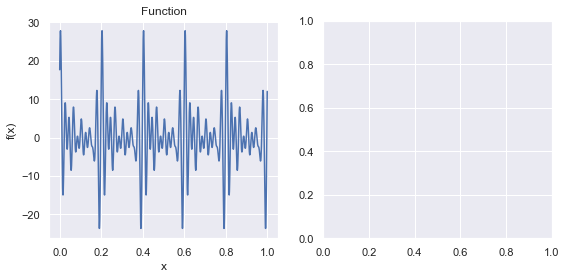

In [37]:
# Data Generation with higher amplitudes on higher frequencies
opt.A = [1 for _ in opt.K[:len(opt.K)//2]] + [5 for _ in opt.K[len(opt.K)//2:]]
opt.PHI = [np.random.rand() for _ in opt.K]

x, y = make_phased_waves(opt)
plot_wave_and_spectrum(opt, x, y)

In [38]:
t, yt = make_phased_waves(opt)
dataset_spectral = SpectralDataset(t, yt)

In [39]:
# make an MLP algorithm which takes inputs of shape (1,)
# has 1 output classes (regression)
# and has different depths
results_list = []
for depth in range(1, 4):
    init_fn, train_step_fn, eval_fn = alg.make_algorithm((1,), 1, n_layers=depth, h_dim=10)

    # these functions initialize the state of the model given a seed, 
    # train on a batch of data, 
    # and evaluate on a batch of data

    # construct a loss-data estimator and use it to compute the loss-data curve
    loss_data_estimator = reprieve.LossDataEstimator(
        init_fn, train_step_fn, eval_fn, dataset_spectral)
    results = loss_data_estimator.compute_curve()
    # name experiments 
    results['name'] = f'Layers-{depth}'
    results_list.append(results)

In [40]:
# concatenate experiments
outcome_df = pd.concat(results_list)

# pick some settings of n (training set size) and epsilon (loss tolerance)
ns = [20, 100, 200, 1000]
epsilons = [80, 70]

In [41]:
# plot the loss-data curves for our representations
reprieve.render_curve(outcome_df, ns, epsilons)

alt.LayerChart(...)

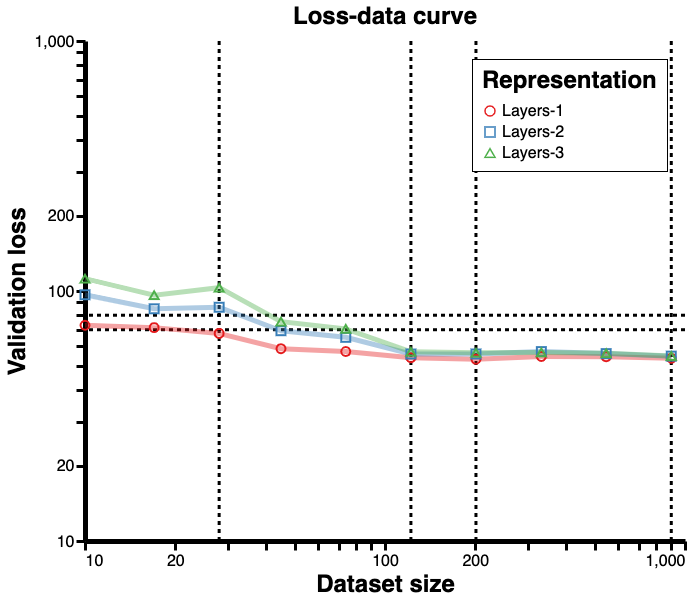

In [2]:
Image(filename='/Users/kati/Documents/CDS/research/IB/notes/squiglier.png')

In [42]:
# compute VA, MDL, SDL, and eSC for both representations
metrics_df = reprieve.compute_metrics(outcome_df, ns, epsilons)
metrics_df

Name,Layers-1,Layers-2,Layers-3,Layers-1,Layers-2,Layers-3,Layers-1,Layers-2,Layers-3,Layers-1,Layers-2,Layers-3
n,28.0,28.0,28.0,122.0,122.0,122.0,201.0,201.0,201.0,900.0,900.0,900.0
Val loss,67.6439,86.0982,103.12,54.0835,55.9745,57.125,53.3662,55.9839,56.6347,53.849,54.8886,54.9477
MDL,1973.04,2507.17,2927.91,7229.03,8265.78,8998.64,11444.96,12688.51,13472.78,49350.61,51636.86,52427.52
"SDL, eps=80",0.0,> 267.17,> 687.91,0.0,267.17,687.91,0.0,267.17,687.91,0.0,267.17,687.91
"SDL, eps=70",38.96,> 547.17,> 967.91,38.96,547.17,1076.64,38.96,547.17,1076.64,38.96,547.17,1076.64
"eSC, eps=80",10,> 28.0,> 28.0,10,45,45,10,45,45,10,45,45
"eSC, eps=70",28,> 28.0,> 28.0,28,45,122,28,45,122,28,45,122
